<a href="https://colab.research.google.com/github/ElizavetaNosova/CAT_academic_checking_form/blob/master/BERT%2B_constrained_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from transformers import BertTokenizer, BertForNextSentencePrediction
from torch.utils.data import Dataset, DataLoader
import numpy as np

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import random
import math
import statistics

from networkx.readwrite import json_graph
import json

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir('gdrive/MyDrive')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

In [ ]:
bert_model = BertForNextSentencePrediction.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The first step is pretraining a classifier. We have tried to use BERT, fine-tuned when we evaluated BERT for next sentnence prediction, but redoing fine-tuning provided better results

In [ ]:
class MLPPairBinaryClassifier(torch.nn.Module):
  def __init__(self, input_dim=768, hidden_dim_1=100, hidden_dim_2=50, bias=False, dropout=0.05):
      super().__init__()
      self.dropout = torch.nn.Dropout(dropout)
      self.linear1 = torch.nn.Linear(input_dim*2, hidden_dim_1, bias=bias)
      self.linear2 = torch.nn.Linear(hidden_dim_1, hidden_dim_2, bias=bias)
      self.classifier = torch.nn.Linear(hidden_dim_2, 1)

  def forward(self, embedding1, embedding2):
      concat_embedding = torch.cat((embedding1, embedding2), -1)
      concat_embedding = self.dropout(torch.tanh(self.linear1(concat_embedding)))
      concat_embedding = self.dropout(torch.tanh(self.linear2(concat_embedding)))
      return torch.sigmoid(self.classifier(concat_embedding))


In [ ]:
class MLPPairBinaryClassifier_v2(torch.nn.Module):
    def __init__(self, input_dim=768, hidden_dim_1=100, hidden_dim_2=50, bias=False, dropout=0.05):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)
        self.linear1 = torch.nn.Linear(input_dim*2, hidden_dim_1, bias=bias)
        self.linear2 = torch.nn.Linear(hidden_dim_1, hidden_dim_2, bias=bias)
        self.classifier = torch.nn.Linear(hidden_dim_2, 2)

    def forward(self, embedding1, embedding2):
      concat_embedding = torch.cat((embedding1, embedding2), -1)
      concat_embedding = self.dropout(torch.tanh(self.linear1(concat_embedding)))
      concat_embedding = self.dropout(torch.tanh(self.linear2(concat_embedding)))
      return torch.softmax(self.classifier(concat_embedding), 1)[:,0]

In [ ]:
MLPclassifier4graph = MLPPairBinaryClassifier_v2()

In [ ]:
MLPclassifier4graph(torch.ones(768,1).t(), torch.ones(768, 1).t())

tensor([0.5453], grad_fn=<SelectBackward>)

In [ ]:
def encoding2cuda(encoding, truncation=None, max_length=512):
    encoding = {key: encoding[key].cuda() for key in encoding}
    if encoding['input_ids'].shape[1] > max_length:
        if truncation == 'l':
            encoding = {key: encoding[key][:, -max_length:].clone() for key in encoding}
        elif truncation == 'r':
             encoding = {key: encoding[key][:, :max_length].clone() for key in encoding}
    return encoding
        

In [ ]:
encoding2.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
[encoding2[key].shape for key in encoding2]

[torch.Size([1, 512]), torch.Size([1, 512]), torch.Size([1, 512])]

In [ ]:
mlp_classifier = MLPPairBinaryClassifier()
mlp_optimizer =  torch.optim.Adam([{'params': mlp_classifier.parameters()}], 
                              lr = 1e-3)
criterion = torch.nn.BCELoss()

In [ ]:
encoding1

{'input_ids': [101, 132, 102], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

In [ ]:
import transformers

In [ ]:
mlp_classifier.cuda()

MLPPairBinaryClassifier(
  (dropout): Dropout(p=0.05, inplace=False)
  (linear1): Linear(in_features=1536, out_features=100, bias=False)
  (linear2): Linear(in_features=100, out_features=50, bias=False)
  (classifier): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
mlp_classifier.train()

MLPPairBinaryClassifier(
  (dropout): Dropout(p=0.05, inplace=False)
  (linear1): Linear(in_features=1536, out_features=100, bias=False)
  (linear2): Linear(in_features=100, out_features=50, bias=False)
  (classifier): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
bert_limit=512
for epoch in range(3):
    for i in range(len(train_dataset)):
        fragment1, fragment2, correct_label = train_dataset[i]
        encoding1 = tokenizer(fragment1, return_tensors='pt')
        encoding2 = tokenizer(fragment2, return_tensors='pt')
        representation1 = bert_model.bert(encoding2cuda(encoding1, truncation='l')['input_ids'])['pooler_output']
        representation2 = bert_model.bert(encoding2cuda(encoding2, truncation='r')['input_ids'])['pooler_output']
        probs = mlp_classifier(representation1, representation2) 

        loss = criterion(torch.squeeze(probs).cpu(), torch.squeeze(torch.tensor([correct_label])).float())
        loss.backward() 
        if i % 50 == 0:
            mlp_optimizer.step()
            mlp_optimizer.zero_grad()
        if i % 1500 == 0:
            torch.save(mlp_classifier.state_dict(), 'mlp_classifier_initial.pth')

In [ ]:
mlp_classifier.load_state_dict(torch.load('mlp_classifier_initial.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
mlp_classifier.cuda()

MLPPairBinaryClassifier(
  (dropout): Dropout(p=0.05, inplace=False)
  (linear1): Linear(in_features=1536, out_features=100, bias=False)
  (linear2): Linear(in_features=100, out_features=50, bias=False)
  (classifier): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
bert_model.eval()
mlp_classifier.eval()

correct = []
predicted = []

with torch.no_grad():
    for fragment1, fragment2, label in test_dataset:
        encoding1 = tokenizer(fragment1, return_tensors='pt')
        encoding2 = tokenizer(fragment2, return_tensors='pt')
        representation1 = bert_model.bert(encoding2cuda(encoding1, truncation='l')['input_ids'])['pooler_output']
        representation2 = bert_model.bert(encoding2cuda(encoding2, truncation='r')['input_ids'])['pooler_output']
        prob = mlp_classifier(representation1, representation2) 

        correct += [label]
        predicted += [float(prob)]

In [ ]:
len(predicted)

19210

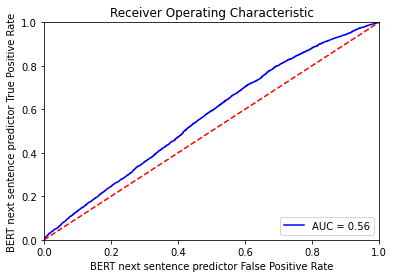

In [ ]:
from sklearn import metrics
fpr_bert, tpr_bert, thresholds_bert = metrics.roc_curve(correct, predicted, pos_label=1)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
roc_ouc = metrics.auc(fpr_bert, tpr_bert)
plt.plot(fpr_bert, tpr_bert, 'b', label = 'AUC = %0.2f' % roc_ouc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('BERT next sentence predictor True Positive Rate')
plt.xlabel('BERT next sentence predictor False Positive Rate')
plt.show()

In [ ]:
torch.save(mlp_classifier, 'mlp_classifier_initial.pth')

In [ ]:
bert_model = BertForNextSentencePrediction.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

In [ ]:
mlp_classifier = MLPPairBinaryClassifier()
#mlp_optimizer =  torch.optim.Adam([{'params': mlp_classifier.parameters()}], 
#                               lr = 1e-3)
#criterion = torch.nn.BCELoss()


In [ ]:
bert_model.cuda()
mlp_classifier.cuda()

In [ ]:
bert_limit=512
for epoch in range(1):
    for i in range(len(train_dataset)):
        fragment1, fragment2, correct_label = train_dataset[i]
        encoding1 = tokenizer(fragment1, return_tensors='pt')
        encoding2 = tokenizer(fragment2, return_tensors='pt')
        representation1 = bert_model.bert(encoding2cuda(encoding1, truncation='l')['input_ids'])['pooler_output']
        representation2 = bert_model.bert(encoding2cuda(encoding2, truncation='r')['input_ids'])['pooler_output']
        probs = mlp_classifier(representation1, representation2) 

        loss = criterion(torch.squeeze(probs).cpu(), torch.squeeze(torch.tensor([correct_label])).float())
        loss.backward() 
        if i % 50 == 0:
            mlp_optimizer.step()
            mlp_optimizer.zero_grad()
        if i % 1500 == 0:
            torch.save(mlp_classifier.state_dict(), 'mlp_classifier_initial.pth')
            print(i/len(train_dataset))

0.0
0.04339022273647671
0.08678044547295342
0.13017066820943013
0.17356089094590685
0.21695111368238357
0.26034133641886026
0.303731559155337
0.3471217818918137
0.39051200462829044
0.43390222736476713
0.4772924501012438
0.5206826728377205
0.5640728955741973
0.607463118310674
0.6508533410471508
0.6942435637836274
0.7376337865201041
0.7810240092565809
0.8244142319930575
0.8678044547295343
0.911194677466011
0.9545849002024877
0.9979751229389644


In [ ]:
bert_model.eval()
mlp_classifier.eval()

correct = []
predicted = []

with torch.no_grad():
    for fragment1, fragment2, label in test_dataset:
        encoding1 = tokenizer(fragment1, return_tensors='pt')
        encoding2 = tokenizer(fragment2, return_tensors='pt')
        representation1 = bert_model.bert(encoding2cuda(encoding1, truncation='l')['input_ids'])['pooler_output']
        representation2 = bert_model.bert(encoding2cuda(encoding2, truncation='r')['input_ids'])['pooler_output']
        prob = mlp_classifier(representation1, representation2) 

        correct += [label]
        predicted += [float(prob)]

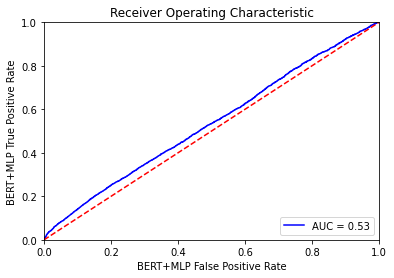

In [ ]:
from sklearn import metrics
fpr_bert, tpr_bert, thresholds_bert = metrics.roc_curve(correct, predicted, pos_label=1)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
roc_ouc = metrics.auc(fpr_bert, tpr_bert)
plt.plot(fpr_bert, tpr_bert, 'b', label = 'AUC = %0.2f' % roc_ouc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('BERT+MLP True Positive Rate')
plt.xlabel('BERT+MLP False Positive Rate')
plt.show()

In [ ]:
optimizer =  torch.optim.Adam([{'params': mlp_classifier.parameters(), 'lr':1e-3}, {'params': bert_model.bert.parameters(), 'lr':1e-5}])

In [ ]:
bert_limit=512
for epoch in range(2):
    for i in range(len(train_dataset)):
        fragment1, fragment2, correct_label = train_dataset[i]
        encoding1 = tokenizer(fragment1, return_tensors='pt')
        encoding2 = tokenizer(fragment2, return_tensors='pt')
        representation1 = bert_model.bert(encoding2cuda(encoding1, truncation='l')['input_ids'])['pooler_output']
        representation2 = bert_model.bert(encoding2cuda(encoding2, truncation='r')['input_ids'])['pooler_output']
        probs = mlp_classifier(representation1, representation2) 

        loss = criterion(torch.squeeze(probs).cpu(), torch.squeeze(torch.tensor([correct_label])).float())
        loss.backward() 
        if i % 50 == 0:
            optimizer.step()
            optimizer.zero_grad()
        if i % 1500 == 0:
            torch.save(mlp_classifier.state_dict(), 'mlp_classifier_initial.pth')
            bert_model.save_pretrained('bert4mlp')
            print(i/len(train_dataset))

In [ ]:
bert_model.eval()
mlp_classifier.eval()

correct = []
predicted = []

with torch.no_grad():
    for fragment1, fragment2, label in test_dataset:
        encoding1 = tokenizer(fragment1, return_tensors='pt')
        encoding2 = tokenizer(fragment2, return_tensors='pt')
        representation1 = bert_model.bert(encoding2cuda(encoding1, truncation='l')['input_ids'])['pooler_output']
        representation2 = bert_model.bert(encoding2cuda(encoding2, truncation='r')['input_ids'])['pooler_output']
        prob = mlp_classifier(representation1, representation2) 

        correct += [label]
        predicted += [float(prob)]

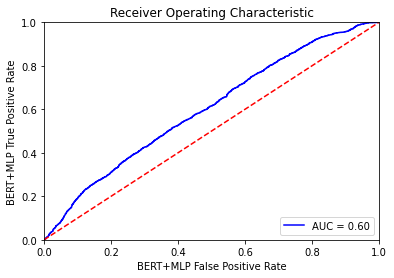

In [ ]:
from sklearn import metrics
fpr_bert, tpr_bert, thresholds_bert = metrics.roc_curve(correct, predicted, pos_label=1)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
roc_ouc = metrics.auc(fpr_bert, tpr_bert)
plt.plot(fpr_bert, tpr_bert, 'b', label = 'AUC = %0.2f' % roc_ouc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('BERT+MLP True Positive Rate')
plt.xlabel('BERT+MLP False Positive Rate')
plt.show()

In [ ]:
bert_model = BertForNextSentencePrediction.from_pretrained('bert4mlp')

In [ ]:
bert_model.cuda()

In [ ]:
def bert_encode_fragment(text, tokenizer, bert):
    bert_limit = 512
    encoding = tokenizer(text, return_tensors='pt')['input_ids'].to(bert.device)
    if encoding.shape[1] <= bert_limit:
        return bert(encoding)['pooler_output']
    else:
       encoding_as_first = encoding[:, -bert_limit:]
       encoding_as_second = encoding[:, :bert_limit]
       return (bert(encoding_as_first)['pooler_output']+bert(encoding_as_second)['pooler_output'])/2

In [ ]:
test = 'кошка '*1000

In [ ]:
bert

In [ ]:
tokenizer(test, return_tensors='pt')['input_ids'].shape

torch.Size([1, 1002])

In [ ]:
with open(os.path.join(BOOK_GRAPHS_DIRECTORY, os.listdir(BOOK_GRAPHS_DIRECTORY)[0]), encoding='utf-8') as f:
    encoding = tokenizer(text, return_tensors='pt')['input_ids'].cuda()
    if encoding.shape[1] <= 512:
        

In [ ]:
bert_model.cuda()

In [ ]:
def get_bert_encoding_json(encoding, bert):
    return [float(i) for i in torch.squeeze(bert(encoding)['pooler_output'])]

In [ ]:
node.keys()

dict_keys(['fragment_text', 'id', 'bert_encoding'])

In [ ]:
bert_limit=512
for file_name in tqdm(os.listdir(ONLINE_GRAPHS_DIRECTORY)):
    book_path = os.path.join(ONLINE_GRAPHS_DIRECTORY, file_name)
    with open(book_path, encoding='utf-8') as f:
        data = json.load(f)
        for node in data['nodes']:
            if 'fragment_text' in node and isinstance(node['fragment_text'], str):
                fragment_text = node['fragment_text']
                encoding = tokenizer(fragment_text, return_tensors='pt')['input_ids'].cuda()
                del node['bert_encoding']
                if encoding.shape[1] <= bert_limit:
                    node['bert_encoding'] = get_bert_encoding_json(encoding, bert_model.bert)
                else:
                    encoding_as_first = encoding[:, -bert_limit:]
                    encoding_as_second = encoding[:, :bert_limit]
                    node['bert_encoding_as_first'] =  get_bert_encoding_json(encoding_as_first, bert_model.bert)
                    node['bert_encoding_as_second'] =  get_bert_encoding_json(encoding_as_second, bert_model.bert)
    with open(book_path, 'w', encoding='utf-8') as f:
        json.dump(data, f)

In [ ]:
for file_name in tqdm(os.listdir(BOOK_GRAPHS_DIRECTORY)):
    book_path = os.path.join(BOOK_GRAPHS_DIRECTORY, file_name)
    with open(book_path, encoding='utf-8') as f:
        data = json.load(f)
        for node in data['nodes']:
            if 'fragment_text' in node and isinstance(node['fragment_text'], str):
                fragment_text = node['fragment_text']
                encoding = tokenizer(fragment_text, return_tensors='pt')['input_ids'].cuda()
                if encoding.shape[1] <= bert_limit:
                    node['bert_encoding'] = get_bert_encoding_json(encoding, bert_model.bert)
                else:
                    encoding_as_first = encoding[:, -bert_limit:]
                    encoding_as_second = encoding[:, :bert_limit]
                    node['bert_encoding_as_first'] =  get_bert_encoding_json(encoding_as_first, bert_model.bert)
                    node['bert_encoding_as_second'] =  get_bert_encoding_json(encoding_as_second, bert_model.bert)
    with open(book_path, 'w', encoding='utf-8') as f:
        json.dump(data, f)

In [ ]:
BOOK_GRAPHS_DIRECTORY

'Quest_data/questbook_graphs'

In [ ]:
test['nodes'][0].keys()

dict_keys(['fragment_text', 'id'])

In [ ]:
class GraphBasedOrderingNetwork(torch.nn.Module):
    def __init__(self, pretrained_MLP, num_iterations, initial_self_coef, update_previous=False, threshold = 0.5, joined_key='bert_encoding', first_key='bert_encoding_as_first', second_key='bert_encoding_as_second'):
        super().__init__()
        self.mlp = pretrained_MLP
        self.num_iterations = num_iterations
        self.self_coef = torch.nn.Linear(1,1, bias=False)
        self.self_coef.weight = torch.nn.Parameter(torch.tensor([[initial_self_coef]]).float())
        self.neighbour_coef = torch.nn.Linear(1,1, bias=False)
        self.neighbour_coef.weight = torch.nn.Parameter(torch.tensor([[1]]).float())
        self.direction = 'previous' if update_previous else 'next'

        self.first_key = first_key
        self.second_key = second_key
        self.joined_key = joined_key
        self.threshold = threshold

    def forward(self, graph=None, path=None, texts=None):
        if graph and path:
            joined_representations, first_representations, second_representations = self.get_initial_representations(graph, path)
        else:
            joined_representations, first_representations, second_representations = self.get_initial_representations4texts(texts)
        probabilities = self.calc_probabilities(first_representations, second_representations )
        for iteration in range(self.num_iterations):
            joined_representations = self.update_representations(joined_representations,  probabilities)
            probabilities  = self.calc_probabilities(joined_representations, joined_representations)
        return probabilities
            


    def get_initial_representations(self, graph, path):
        nodes = graph.nodes()

        path_representations_as_first = []
        path_representation_as_second = []

        path_representations_joined = []
        for node in path:
            if self.joined_key in nodes[node]:
               for representations in  path_representations_joined, path_representations_as_first, path_representation_as_second:
                   representations.append(torch.tensor(nodes[node][self.joined_key]))
            elif self.first_key in nodes[node] and self.second_key in nodes[node]:
                encoding_as_first = torch.tensor(nodes[node][self.first_key])
                encoding_as_second =  torch.tensor(nodes[node][self.second_key])
                path_representations_as_first.append(encoding_as_first)
                path_representation_as_second.append(encoding_as_second)
                path_representations_joined.append(0.5*encoding_as_first+0.5*encoding_as_second)
            else:
                raise ValueError('Graph should contain bert encoding of texts')
        return self.cat_representations(path_representations_joined).t(),  self.cat_representations(path_representations_as_first).t(), self.cat_representations(path_representation_as_second).t()

    def get_initial_representations4texts(self, texts):

        path_representations_as_first = []
        path_representation_as_second = []

        path_representations_joined = []

        for text in texts:
            encoding = tokenizer(text, return_tensors='pt')['input_ids']
            if encoding.shape[1] <= bert_limit:
                bert_encoding = get_bert_encoding_json(encoding, bert_model.bert)
                for representations in  path_representations_joined, path_representations_as_first, path_representation_as_second:
                    representations.append(bert_encoding)

            else:
                encoding_as_first = encoding[:, -bert_limit:]
                encoding_as_second = encoding[:, :bert_limit]
                path_representations_as_first.append(encoding_as_first)
                path_representation_as_second.append(encoding_as_second)
                path_representations_joined.append(0.5*encoding_as_first+0.5*encoding_as_second)
        return self.cat_representations(path_representations_joined).t(),  self.cat_representations(path_representations_as_first).t(), self.cat_representations(path_representation_as_second).t()

    
    
    
    def cat_representations(self, representations):
        print(representations)
        return torch.cat([torch.unsqueeze(torch.tensor(tensor), 1) for tensor in representations], 1)

    def calc_probabilities(self, first_representations, second_representations):
        assert first_representations.shape == second_representations.shape
        num_fragments = first_representations.shape[0]
        probabilities = torch.zeros(num_fragments, num_fragments)
        for i, first_representation in enumerate(first_representations):
            for j, second_representation in enumerate(second_representations):
                if i != j:
                    probabilities[i][j] = torch.squeeze(self.mlp(torch.unsqueeze(first_representation, 0), torch.unsqueeze(second_representation, 0)))
        return probabilities

    
    def update_representations(self, representations, probabilities):
        unsqueezed_representations = torch.unsqueeze(representations, 2)
        new_representations =  unsqueezed_representations.clone()
        new_representatios = self.self_coef(new_representations)

        for i, probability_vector in enumerate(probabilities):
            for j, probability in enumerate(probability_vector):
                if probability >= self.threshold:
                    if self.direction == 'next':
                        new_representations[j] = new_representations[j].clone() + probability*self.neighbour_coef(unsqueezed_representations[i]).clone()
                    else:
                        new_representations[i] = new_representations[i].clone() + self.neighbour_coef(unsqueezed_representationss[j]).clone()
        return torch.squeeze(new_representations)

In [ ]:
pretrained_MLP = MLPPairBinaryClassifier()
pretrained_MLP.load_state_dict(torch.load('mlp_classifier_initial.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
MLPclassifier4graph = MLPPairBinaryClassifier_v2()

In [ ]:
MLPclassifier4graph

In [ ]:
MLPclassifier4graph.linear1 = pretrained_MLP.linear1
MLPclassifier4graph.linear2 = pretrained_MLP.linear2

In [ ]:
model = GraphBasedOrderingNetwork(MLPclassifier4graph, num_iterations=1, initial_self_coef=1, threshold=0.1)

In [ ]:
optimizer = torch.optim.Adam([{'params': model.parameters()}], 
                               lr = 1e-3)
criterion = torch.nn.BCELoss()

In [ ]:
BOOK_PATHS_DIRECTORY = os.path.join('Quest_data', 'book_paths')
ONLINE_PATHS_DIRECTORY = os.path.join('Quest_data', 'random_paths')


In [ ]:

dev_online_paths, test_online_paths = train_test_split(os.listdir(ONLINE_PATHS_DIRECTORY), random_state=42, test_size=0.4)

all_dev_paths = [('book', book_paths_file) for book_paths_file in os.listdir(BOOK_PATHS_DIRECTORY)] + [('online', online_paths_file) for online_paths_file in dev_online_paths]

train_paths, valid_paths = train_test_split(all_dev_paths, random_state=42, test_size=0.1)

In [ ]:
def correct_path(path, graph, text_key):
    nodes = G.nodes()
    return [node_id for node_id in path if text_key in nodes[node_id] and isinstance(nodes[node_id][text_key], str)]

In [ ]:
model.training

True

In [ ]:
num_samples = 0
for quest_type, file_name in tqdm(train_paths[3:]):
    text_key = 'fragment_text'
    try:
        if quest_type == 'book':
            paths_directory = BOOK_PATHS_DIRECTORY
            quests_directory = BOOK_GRAPHS_DIRECTORY
        else:
            paths_directory = ONLINE_PATHS_DIRECTORY
            quests_directory = ONLINE_GRAPHS_DIRECTORY

        with open(os.path.join(paths_directory, file_name), encoding='utf-8') as f:
            paths = json.load(f)

        with open(os.path.join(quests_directory,  file_name), encoding='utf-8') as f:
            G = json_graph.node_link_graph(json.load(f))
        
        for path in paths:
            corrected_path = correct_path(path, G, text_key)
            if len(corrected_path) > 3:
                predicted = model(G, corrected_path)[1:, :-1].clone().cpu()
                correct = torch.eye(predicted.shape[0])
                loss = criterion(predicted, correct)
                loss.backward()
                num_samples += 1
                if num_samples % 10 == 0:
                    optimizer.step()
                    optimizer.zero_grad()
                if num_samples % 200 == 0:
                    torch.save(model.state_dict(), 'construted_graph_model.pth')
    #if some graph files are deleted, but random paths exist
    except FileNotFoundError:
        pass

In [ ]:
model.load_state_dict(torch.load('construted_graph_model.pth'))

<All keys matched successfully>

In [ ]:
predictions = []
num_samples = 0
for file_name in tqdm(test_online_paths):
    try:
        paths_directory = ONLINE_PATHS_DIRECTORY
        quests_directory = ONLINE_GRAPHS_DIRECTORY
        text_key = 'fragment_text'

        with open(os.path.join(paths_directory, file_name), encoding='utf-8') as f:
            paths = json.load(f)

        with open(os.path.join(quests_directory,  file_name), encoding='utf-8') as f:
            G = json_graph.node_link_graph(json.load(f))


        with torch.no_grad(): 
            for path in paths:
                corrected_path = correct_path(path, G, text_key)
                if len(corrected_path) > 3:
                    predicted = model(G, corrected_path).tolist()
                    predictions.append(predicted)
                    num_samples += 1
                if num_samples % 200 == 0:
                    with open('BERT_graph_predictions.json', 'w', encoding = 'utf-8') as f:
                        json.dump(predictions, f)
    #if some graph files are deleted, but random paths exist
    except FileNotFoundError:
        pass


100%|██████████| 76/76 [59:07<00:00, 46.68s/it]


In [ ]:
with open('BERT_graph_predictions.json') as f:
    predictions = json.load(f)

In [ ]:
[1,2,3].index(max([1,2,3]))

2

In [ ]:
def transitions_table_beam_search(transition_table, num_candidates = 3):
    best_order_candidates = [{'order':[0], 'probability':1}]
    for i in range(len(transition_table)-1):
        next_step_order_candidates = []
        for best_candidate in best_order_candidates:
            current_step_data = transition_table[best_candidate['order'][-1]]
            candidate_current_step_probabilities = [score if i not in best_candidate['order'] else 0 for i, score in enumerate(current_step_data)]
            for i in range(min(num_candidates, len([i for i in candidate_current_step_probabilities if i]))):
                max_probability = max(candidate_current_step_probabilities)
                max_probability_idx = candidate_current_step_probabilities.index(max_probability)
                next_step_order_candidates.append({'order': best_candidate['order'] + [max_probability_idx], 'probability':  best_candidate['probability']*max_probability})

        #if all unordered candidates have zero probability
        if next_step_order_candidates:
            next_step_order_candidates.sort(key=lambda x: x['probability'], reverse=True)
            best_order_candidates = next_step_order_candidates[:num_candidates]
        else:
            break

        result = best_order_candidates[0]['order']
        #if we went out the loop before all the candidates were ordered because of zero probabilities, the last candidates will have random order
        if len(result) < len(transition_table):
            unordered_items = [i for i in range(len(transition_table)) if i not in result]
            random.shuffle(unordered_items)
            result += unordered_items
        return result

In [ ]:
import torch

In [ ]:
def transitions_table_beam_search_vertical(transition_table, num_candidates = 3):
    transition_table = torch.tensor(transition_table).t().tolist()
    best_order_candidates = [{'order':[0], 'probability':1}]
    for i in range(len(transition_table)-1):
        next_step_order_candidates = []
        for best_candidate in best_order_candidates:
            current_step_data = transition_table[best_candidate['order'][-1]]
            candidate_current_step_probabilities = [score if i not in best_candidate['order'] else 0 for i, score in enumerate(current_step_data)]
            for i in range(min(num_candidates, len([i for i in candidate_current_step_probabilities if i]))):
                max_probability = max(candidate_current_step_probabilities)
                max_probability_idx = candidate_current_step_probabilities.index(max_probability)
                next_step_order_candidates.append({'order': best_candidate['order'] + [max_probability_idx], 'probability':  best_candidate['probability']*max_probability})

        #if all unordered candidates have zero probability
        if next_step_order_candidates:
            next_step_order_candidates.sort(key=lambda x: x['probability'], reverse=True)
            best_order_candidates = next_step_order_candidates[:num_candidates]
        else:
            break

        result = best_order_candidates[0]['order']
        #if we went out the loop before all the candidates were ordered because of zero probabilities, the last candidates will have random order
        if len(result) < len(transition_table):
            unordered_items = [i for i in range(len(transition_table)) if i not in result]
            random.shuffle(unordered_items)
            result += unordered_items
        return result

In [ ]:
def scoring_transitions_table_beam_search_vertical(transition_table, num_candidates = 3, epsilon = 10**(-1)):
    transition_table = torch.tensor(transition_table).t().tolist()
    best_order_candidates = [{'order':[0], 'probability':0}]
    for i in range(len(transition_table)-1):
        next_step_order_candidates = []
        for best_candidate in best_order_candidates:
            current_step_data = transition_table[best_candidate['order'][-1]]
            candidate_current_step_probabilities = [score if i not in best_candidate['order'] else 0 for i, score in enumerate(current_step_data)]
            for i in range(min(num_candidates, len([i for i in candidate_current_step_probabilities if i]))):
                max_probability = max(candidate_current_step_probabilities)
                max_probability_idx = candidate_current_step_probabilities.index(max_probability)
                score = max_probability if max_probability > 0 else epsilon
                next_step_order_candidates.append({'order': best_candidate['order'] + [max_probability_idx], 'probability':  best_candidate['probability']+math.log(score)})

        #if all unordered candidates have zero probability
        if next_step_order_candidates:
            next_step_order_candidates.sort(key=lambda x: x['probability'], reverse=True)
            best_order_candidates = next_step_order_candidates[:num_candidates]
        else:
            break

        result = best_order_candidates[0]['order']
        #if we went out the loop before all the candidates were ordered because of zero probabilities, the last candidates will have random order
        if len(result) < len(transition_table):
            unordered_items = [i for i in range(len(transition_table)) if i not in result]
            random.shuffle(unordered_items)
            result += unordered_items
        return {'order': result, 'score': best_order_candidates[0]['probability']}

In [ ]:
def scoring_full_pipeline(texts):
    transition_table = model(texts=texts)
    return scoring_transitions_table_beam_search_vertical(transition_table)

In [ ]:
sanity_check_data.keys()

dict_keys(['real', 'random'])

In [ ]:
real_predictions = [scoring_full_pipeline(texts) for texts in sanity_check_data['real']]
random_predictions = [scoring_full_pipeline(texts) for texts in sanity_check_data['random']]

In [ ]:
real_predictions

[{'order': [0, 2, 5, 8, 4, 7, 6, 1, 3], 'score': -2.4194957613008907},
 {'order': [0, 1, 3, 2], 'score': -2.474313748937901},
 {'order': [0, 17, 8, 10, 16, 9, 7, 5, 12, 6, 1, 2, 14, 3, 13, 15, 11, 4],
  'score': -2.5942340231430383},
 {'order': [0, 4, 2, 3, 7, 8, 5, 6, 9, 1], 'score': -2.6592002169460476},
 {'order': [0, 12, 13, 1, 7, 9, 18, 2, 16, 15, 5, 4, 8, 11, 10, 17, 6, 3, 14],
  'score': -1.8909375306996838}]

In [ ]:
statistics.mean([sample['score'] for sample in real_predictions])

-2.4076362562055125

In [ ]:
statistics.mean([sample['score'] for sample in random_predictions])

-193.81721110523338

In [ ]:
from scipy.stats import kendalltau
import pandas as pd

def longest_correct_subsequence(predicted, correct):
    correct_transitions = set([(item_from, item_to) for item_from, item_to in zip(correct[:-1], correct[1:])])
    predicted_transitions = [(item_from, item_to) for item_from, item_to in zip(predicted[:-1], predicted[1:])]
    predicted_transitions_are_correct = [transition in correct_transitions for transition in predicted_transitions]
    
    longest_correct_transitions_subsequence = 0
    current_correct_transitions_subsequence = 0
    #Add False as last item to include last real item checking into the loop
    for predicted_transition_is_correct in predicted_transitions_are_correct + [False]:
        if predicted_transition_is_correct:
            current_correct_transitions_subsequence += 1
        else:
            if current_correct_transitions_subsequence > longest_correct_transitions_subsequence:
                longest_correct_transitions_subsequence = current_correct_transitions_subsequence
            current_correct_transitions_subsequence = 0
    #return number of items in longest correct sequence (not number of transitions)
    return longest_correct_transitions_subsequence + 1 if longest_correct_transitions_subsequence else 0  

In [ ]:
bert_graph_df = pd.DataFrame(columns=['length', "Kendall's tau", "longest subsequence"])

for transition_table in predictions:
    predicted_order = transitions_table_beam_search(transition_table)
    correct_order = [i for i in range(len(predicted_order))]
    tau = kendalltau(predicted_order[1:], correct_order[1:]).correlation
    longest_subsequence = longest_correct_subsequence(predicted_order, correct_order)

    bert_graph_df.loc[len(bert_graph_df)] = [len(predicted_order), tau, longest_subsequence]

In [ ]:
bert_graph_df

,length,Kendall's tau,longest subsequence
0,7.0,0.200000,3.0
1,9.0,-0.642857,0.0
2,10.0,0.111111,2.0
3,9.0,0.428571,2.0
4,7.0,0.066667,0.0
...,...,...,...
3195,6.0,0.200000,0.0
3196,6.0,-0.200000,0.0
3197,6.0,0.200000,0.0
3198,4.0,-0.333333,2.0


In [ ]:
latex_plain_text = bert_graph_aggr.to_latex()
with open('latex_draft.txt', 'w') as f:
    f.write(latex_plain_text)

In [ ]:
from google.colab import files
files.download('latex_draft.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
bert_graph_df = pd.DataFrame(columns=['length', "Kendall's tau", "longest subsequence"])

for transition_table in predictions:
    predicted_order = transitions_table_beam_search_vertical(transition_table)
    correct_order = [i for i in range(len(predicted_order))]
    tau = kendalltau(predicted_order[1:], correct_order[1:]).correlation
    longest_subsequence = longest_correct_subsequence(predicted_order, correct_order)

    bert_graph_df.loc[len(bert_graph_df)] = [len(predicted_order), tau, longest_subsequence]

In [ ]:
bert_graph_aggr = bert_graph_df[bert_graph_df["length"]<=30].groupby("length").describe()[[("Kendall's tau", 'count'), ("Kendall's tau",  'mean'), ('longest subsequence',  'mean')]]
bert_graph_aggr

Kendall's tau           longest subsequence
               count      mean                mean
length                                            
3.0             44.0 -0.363636            0.954545
4.0             65.0 -0.292308            1.200000
5.0             53.0 -0.062893            1.075472
6.0            100.0 -0.070000            1.390000
7.0            107.0 -0.079128            1.224299
8.0             92.0 -0.043478            1.434783
9.0            166.0  0.009897            1.445783
10.0           192.0 -0.000289            1.239583
11.0           188.0 -0.019149            1.393617
12.0           174.0  0.017555            1.477011
13.0           159.0 -0.020011            1.389937
14.0           155.0  0.023656            1.232258
15.0           144.0  0.008394            1.444444
16.0           108.0 -0.035273            1.370370
17.0            82.0  0.028659            1.365854
18.0            75.0 -0.010588            1.186667
19.0            74.0 -0.003003            1.310811
20.0            61.0 -0.048797            1.163934
21.0            69.0 -0.037986            1.492754
22.0            77.0 -0.011750            1.155844
23.0            57.0  0.006759            1.280702
24.0            47.0 -0.003953            1.148936
25.0            57.0 -0.024663            1.385965
26.0            35.0  0.000762            1.371429
27.0            42.0 -0.028425            1.047619
28.0            37.0 -0.016709            1.297297
29.0            62.0  0.015788            1.338710
30.0            43.0 -0.006186            1.162791

In [ ]:
latex_plain_text = bert_graph_aggr.to_latex()
with open('latex_draft.txt', 'w') as f:
    f.write(latex_plain_text)

In [ ]:
from google.colab import files
files.download('latex_draft.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>